# <font color="#F48E16">Formación en XAI de Deep Learning: Explicabilidad específica - Regresión lineal y logística</font>

Material generado por <a href="https://www.linkedin.com/in/christian-oliva-moya-ingeniero/">Christian Oliva</a>. Cualquier duda, sugerencia o errata, no duden en contactar.

**Versión 1.0** - 29 de agosto de 2025

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kagglehub
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

## <font color="#F48E16">Datos</font>

En este notebook se muestra la implementación manual de los diferentes algoritmos de explicabilidad genérica vistos durante el curso, que son los siguientes:

- Importancia por permutación

- Relevancia por oclusión

- SHAP

- LIME

Para ello, se van a utilizar diferentes modelos sencillos de SKLearn sobre un dataset de riesgo financiero para la aprobación de préstamos: **Loan Approval Classification Dataset**

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

<hr>

En el notebook se desarrolla el código por completo según una fase sencilla de preprocesamiento de los datos, el entrenamiento de algunos modelos y la explicabilidad utilizando los diferentes algoritmos.

### Descarga de datos de Kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-approval-classification-data


In [3]:
data = pd.read_csv(path + "/loan_data.csv")
data

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [4]:
data["person_age"] = np.log(np.clip(data["person_age"], 0, 70))
data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
data["person_income"] = np.log(data["person_income"])
data["person_emp_exp"] = np.log(data["person_emp_exp"]+1)
data = pd.concat((data, pd.get_dummies(data["person_home_ownership"], prefix="person_home_ownership_")), axis=1)
data = data.drop(columns=["person_home_ownership"])
data["loan_amnt"] = np.log(data["loan_amnt"])
data = pd.concat((data, pd.get_dummies(data["loan_intent"], prefix="loan_intent_")), axis=1)
data = data.drop(columns=["loan_intent"])
data["loan_percent_income"] = np.log(data["loan_percent_income"]+0.1)
data["cb_person_cred_hist_length"] = np.log(data["cb_person_cred_hist_length"])
data["previous_loan_defaults_on_file"] = data["previous_loan_defaults_on_file"].replace({"No": 0, "Yes": 1})

/tmp/ipython-input-2525706371.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
/tmp/ipython-input-2525706371.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
/tmp/ipython-input-2525706371.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old 

### Separación en TRAIN-TEST y normalización

In [5]:
X = data.drop(columns=["loan_status"])
y = data["loan_status"]

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
means = X_train_raw.mean()
stds = X_train_raw.std()
X_train = (X_train_raw-means) / stds
X_test = (X_test_raw-means) / stds

In [8]:
X_train.describe()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
count,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,...,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04
mean,-2.044587e-15,-8.092292e-18,3.088887e-17,-1.318254e-15,-4.144833e-18,-1.299504e-15,1.139681e-15,1.340163e-16,-2.197748e-16,-6.506400e-16,...,-8.990339e-17,1.973730e-19,7.065953e-17,1.028313e-16,6.710681e-17,1.302662e-17,2.171103e-17,5.279727e-18,-2.072416e-17,6.118562e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.634282e+00,-1.106582e+00,-1.288573e+00,-3.820060e+00,-1.480771e+00,-3.838885e+00,-1.867012e+00,-2.348392e+00,-1.469157e+00,-4.827681e+00,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
25%,-6.664523e-01,-1.106582e+00,-1.288573e+00,-6.451277e-01,-7.631502e-01,-5.969609e-01,-8.101133e-01,-8.153795e-01,-7.966108e-01,-6.094639e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
50%,-2.415560e-01,9.036589e-01,-3.606891e-01,-1.742892e-02,1.854926e-01,6.478053e-02,2.628404e-03,-7.049805e-02,-3.194316e-01,1.466317e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
75%,5.180761e-01,9.036589e-01,5.671948e-01,6.186931e-01,7.940326e-01,6.646859e-01,6.782409e-01,7.276121e-01,8.302939e-01,7.435493e-01,...,1.197169e+00,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
max,5.015846e+00,9.036589e-01,2.422962e+00,8.343544e+00,3.526269e+00,2.142782e+00,3.009438e+00,3.394679e+00,3.022695e+00,4.325055e+00,...,1.197169e+00,1.904275e+01,3.759257e+00,9.603814e-01,2.298147e+00,1.969081e+00,2.905366e+00,2.068821e+00,2.229352e+00,2.186582e+00


In [9]:
columnas = X_train_raw.columns
columnas

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'person_home_ownership__MORTGAGE',
       'person_home_ownership__OTHER', 'person_home_ownership__OWN',
       'person_home_ownership__RENT', 'loan_intent__DEBTCONSOLIDATION',
       'loan_intent__EDUCATION', 'loan_intent__HOMEIMPROVEMENT',
       'loan_intent__MEDICAL', 'loan_intent__PERSONAL',
       'loan_intent__VENTURE'],
      dtype='object')

In [10]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [11]:
X_train.shape, y_train.shape

((36000, 21), (36000,))

## <font color="#F48E16">Funciones de Explicabilidad genérica</font>

In [12]:
def importancia_permutacion(X, y, model, N=10):
    Rx = np.zeros(X.shape[1])
    for i in tqdm(range(X.shape[1])):
        for j in range(N):
            X_perm = X.copy()
            np.random.shuffle(X_perm[:, i])
            Rx[i] += model.score(X_perm, y)
    Rx = model.score(X, y) - Rx / N
    return Rx

In [13]:
def relevancia_oclusion(X, y, model, verbose=True):
  if X.ndim == 1: # 1 solo dato, lo ponemos en formato matricial
    X = X[None, :]
    pred = model.predict_proba(X)
  else:
    score = model.score(X, y)

  num_atributos = X.shape[-1]

  iterador_num_atributos = tqdm(range(num_atributos)) if verbose else range(num_atributos)
  Rx = np.zeros(num_atributos)
  for i in iterador_num_atributos:
    X_null = X.copy()
    X_null[:, i] = 0
    if X.shape[0] == 1: # solo un dato, relevancia local
      Rx[i] = pred[0,y] - model.predict_proba(X_null)[0,y]
    else: # más de un dato, relevancia global
      Rx[i] = score - model.score(X_null, y)
  return Rx

In [14]:
def shap(X, y, model, item, N=10, verbose=True):
    num_atributos = X.shape[1]
    shap_values = np.zeros(num_atributos)
    x = X[item][None, :]
    y = y[item]

    baseline = model.predict_proba(X).mean(axis=0, keepdims=True)

    iterador_N = tqdm(range(N)) if verbose else range(N)
    for _ in iterador_N:
      prev_pred = baseline
      perm = np.random.permutation(num_atributos)
      for c, i in enumerate(perm):
        x_S = x.copy()
        x_S[:, perm[c+1:]] = X.mean(axis=0)[perm[c+1:]] # Esta estrategia puede ser diferente
        pred = model.predict_proba(x_S)
        shap_values[i] += (pred - prev_pred)[0,y]
        prev_pred = pred

    return shap_values / N

In [15]:
def lime(X, y, model, item, D=1000):
  num_atributos = X.shape[1]
  x0 = X[item][None, :]
  y = y[item]

  # 1. Generamos dataset sintetico X_perturbed alrededor de x0
  X_perturbed = np.repeat(x0, D, axis=0)
  noise = np.random.normal(size=X_perturbed.shape) * X.std(axis=0, keepdims=True)
  X_perturbed += noise

  # 2. Se calculan las predicciones del modelo sobre X_perturbed
  y_perturbed = model.predict_proba(X_perturbed)[:, y]

  # 3. Se asignan pesos a los puntos de X_perturbed según la distancia a x0
  distances = np.linalg.norm(X_perturbed - x0, axis=1) + 1e-8
  weights = 1 / distances # más distancia, menor peso. Esta estrategia puede ser diferente

  # 4. Se entrena un modelo lineal con los puntos de X_perturbed
  linear_model = LinearRegression()
  linear_model.fit(X_perturbed, y_perturbed, sample_weight=weights) # NO OLVIDAR sample_weights
  Rx = linear_model.coef_

  return Rx

## <font color="#F48E16">Coeficiente de Explicabilidad-Rendimiento</font>

In [16]:
def epc(X, y, model, Rx, local=False):
  at = Rx.shape[-1]
  m = model.score(X, y)
  epc_all = []
  if not local: # Si es global
    for i in range(at):
        ar = at - i
        factor1 = (at - ar) / at

        umbral = np.sort(Rx[0])[i] # Usamos el mismo umbral para todo el dataset

        # Prueba 1
        X_prueba1 = X.copy()
        X_prueba1[Rx <= umbral] = 0
        mmas = model.score(X_prueba1, y)

        # Prueba 2
        X_prueba2 = X.copy()
        X_prueba2[Rx >= umbral] = 0
        mmenos = model.score(X_prueba2, y)

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)

  else: # Si es local
    for i in range(at):
        ar = at - i
        factor1 = (at - ar) / at

        # Prueba 1
        X_prueba1 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Por cada instancia x hay una relevancia r
            umbral = np.sort(r)[i] # y tenemos que usar esa r para definir el umbral
            X_prueba1[j, r <= umbral] = 0
        mmas = model.score(X_prueba1, y)

        # Prueba 2
        X_prueba2 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Lo mismo aquí con la prueba 2
            umbral = np.sort(r)[i]
            X_prueba2[j, r >= umbral] = 0
        mmenos = model.score(X_prueba2, y)

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)

  return np.array(epc_all)

## <font color="#F48E16">Explicabilidad específica de la regresión lineal y logística</font>

**IMPORTANTE**: Por simplicidad para los algoritmos más pesados, vamos a utilizar solo un trocito de X_train como si fuese nuestro dataset completo.

In [17]:
X_train_small = X_train[:100]
y_train_small = y_train[:100]

### Caso 1: Regresión Logística "normal"

In [18]:
rl = LogisticRegression()
rl.fit(X_train, y_train)
rl.score(X_test, y_test)

0.8955555555555555

In [19]:
Rx_perm_rl = importancia_permutacion(X_train, y_train, rl, N=10)
Rx_oclu_rl = relevancia_oclusion(X_train, y_train, rl, verbose=False)
Rx_oclu_local_rl = np.array([relevancia_oclusion(X_train_small[item], y_train_small[item], rl, verbose=False) for item in range(len(X_train_small))])
Rx_shap_rl = np.array([shap(X_train_small, y_train_small, rl, item, N=50, verbose=False) for item in range(len(X_train_small))])
Rx_lime_rl = np.array([lime(X_train_small, y_train_small, rl, item) for item in range(len(X_train_small))])

100%|██████████| 21/21 [00:05<00:00,  4.04it/s]


In [20]:
epc_perm_rl = epc(X_train, y_train, rl, np.repeat(Rx_perm_rl[None, :], X_train.shape[0], axis=0))
epc_oclu_rl = epc(X_train, y_train, rl, np.repeat(Rx_oclu_rl[None, :], X_train.shape[0], axis=0))
epc_oclu_local_rl = epc(X_train_small, y_train_small, rl, Rx_oclu_local_rl, local=True)
epc_shap_rl = epc(X_train_small, y_train_small, rl, Rx_shap_rl, local=True)
epc_lime_rl = epc(X_train_small, y_train_small, rl, (Rx_lime_rl*np.sign(X_train_small)), local=True) # Tenemos que multiplicar aquí por el signo de x

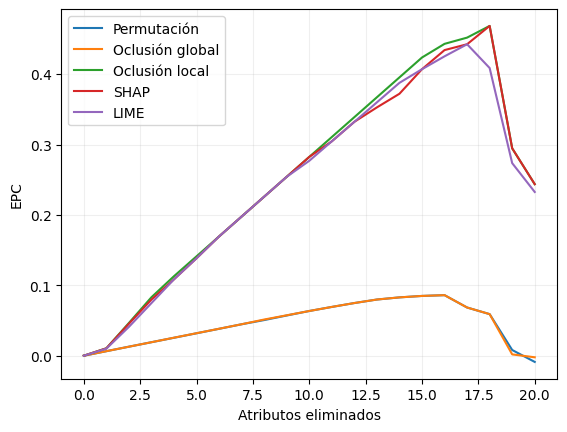

In [21]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

Hasta aquí, el notebook del bloque de la semana pasada.

<hr>

Veamos qué representan realmente los pesos:

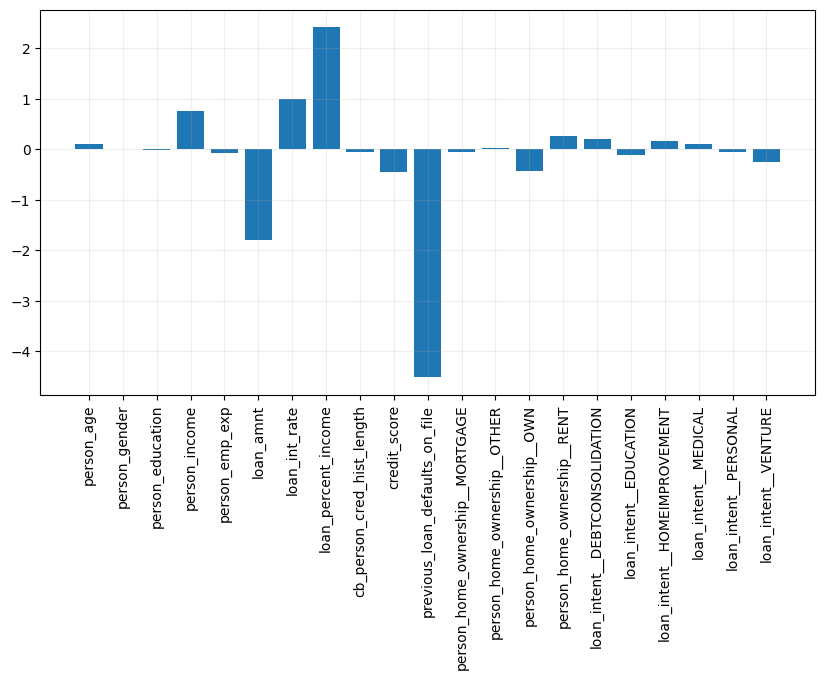

In [22]:
plt.figure(figsize=(10, 5))
plt.bar(columnas, rl.coef_[0])
plt.xticks(rotation=90)
plt.grid(alpha=0.2)

Vamos a calcular las relevancias:

In [23]:
Rx_weights_global_rl = np.abs(rl.coef_)
Rx_weights_local_rl = rl.coef_ * (y_train_small*2-1)[:, None] # Tenemos que multiplicar por y_train_small. ¿Por qué?

In [24]:
epc_weights_global_rl = epc(X_train, y_train, rl, np.repeat(Rx_weights_global_rl, X_train.shape[0], axis=0))
epc_weights_local_rl = epc(X_train_small, y_train_small, rl, (Rx_weights_local_rl * np.sign(X_train_small)), local=True) # Tenemos que multiplicar aquí por el signo de x

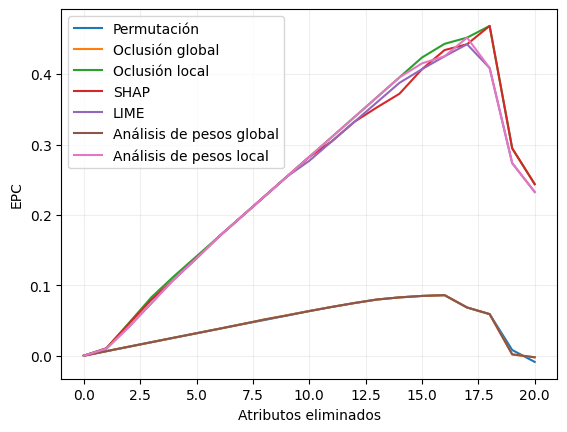

In [25]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.plot(epc_weights_global_rl, label="Análisis de pesos global")
plt.plot(epc_weights_local_rl, label="Análisis de pesos local")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

**¿Conclusiones?**

- El análisis de pesos global ($|Rx|$) funciona prácticamente igual en este caso. Es un resultado razonable y es instantáneo en coste computacional (solo hay que mirar los pesos de la regresión lineal).

- Con el análisis de pesos local pasa algo parecido. Funciona prácticamente igual y el coste computacional es nulo en comparación con SHAP y LIME.

### Caso 2: Regresión Logística regularizada

In [26]:
rl = LogisticRegression(penalty="l1", solver="saga", C=0.01)
rl.fit(X_train, y_train)
rl.score(X_test, y_test)

0.8952222222222223

Veamos ahora los pesos:

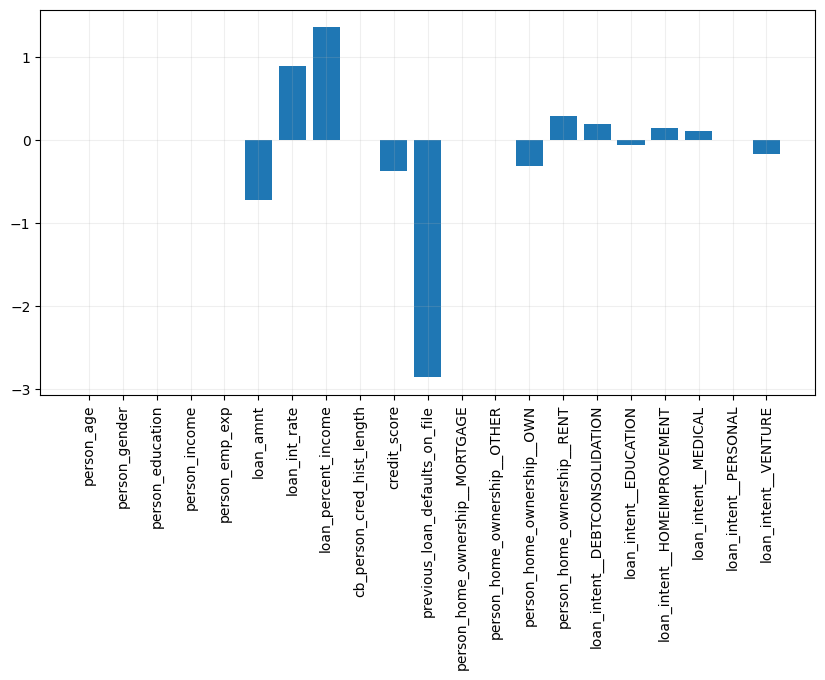

In [27]:
plt.figure(figsize=(10, 5))
plt.bar(columnas, rl.coef_[0])
plt.xticks(rotation=90)
plt.grid(alpha=0.2)

**¿Qué está sucediendo?**

- La regularización L1 en la regresión logística anula directamente atributos de entrada que el modelo considera innecesarios. Como $w_i = 0$, tal y como hemos visto, eliminarlo no hará nada.

Volvemos a calcular todo para este nuevo modelo:

In [28]:
Rx_perm_rl = importancia_permutacion(X_train, y_train, rl, N=10)
Rx_oclu_rl = relevancia_oclusion(X_train, y_train, rl, verbose=False)
Rx_oclu_local_rl = np.array([relevancia_oclusion(X_train_small[item], y_train_small[item], rl, verbose=False) for item in range(len(X_train_small))])
Rx_shap_rl = np.array([shap(X_train_small, y_train_small, rl, item, N=50, verbose=False) for item in range(len(X_train_small))])
Rx_lime_rl = np.array([lime(X_train_small, y_train_small, rl, item) for item in range(len(X_train_small))])

100%|██████████| 21/21 [00:01<00:00, 14.12it/s]


In [29]:
epc_perm_rl = epc(X_train, y_train, rl, np.repeat(Rx_perm_rl[None, :], X_train.shape[0], axis=0))
epc_oclu_rl = epc(X_train, y_train, rl, np.repeat(Rx_oclu_rl[None, :], X_train.shape[0], axis=0))
epc_oclu_local_rl = epc(X_train_small, y_train_small, rl, Rx_oclu_local_rl, local=True)
epc_shap_rl = epc(X_train_small, y_train_small, rl, Rx_shap_rl, local=True)
epc_lime_rl = epc(X_train_small, y_train_small, rl, (Rx_lime_rl*np.sign(X_train_small)), local=True) # Tenemos que multiplicar aquí por el signo de x

Ahora calculamos las relevancias para el análisis de pesos

In [30]:
Rx_weights_global_rl = np.abs(rl.coef_)
Rx_weights_local_rl = rl.coef_ * (y_train_small*2-1)[:, None] # Tenemos que multiplicar por y_train_small. ¿Por qué?

In [31]:
epc_weights_global_rl = epc(X_train, y_train, rl, np.repeat(Rx_weights_global_rl, X_train.shape[0], axis=0))
epc_weights_local_rl = epc(X_train_small, y_train_small, rl, (Rx_weights_local_rl * np.sign(X_train_small)), local=True) # Tenemos que multiplicar aquí por el signo de x

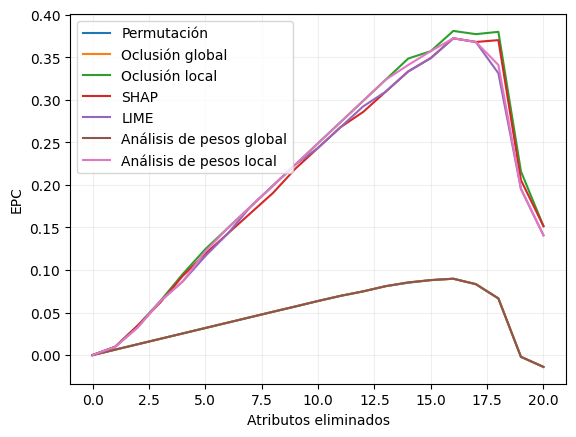

In [32]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.plot(epc_weights_global_rl, label="Análisis de pesos global")
plt.plot(epc_weights_local_rl, label="Análisis de pesos local")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

**¿Conclusiones?**

- La regularización ayuda a anular atributos. Esto parece evidente, pero será muy útil cuando los modelos empiecen a complicarse.